## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from pymongo import MongoClient
from pymongo.errors import ConnectionFailure

import os
import warnings
warnings.filterwarnings('ignore')

## MongoDB Configuration

In [2]:
!mongod --config /usr/local/etc/mongod.conf
!brew services start mongodb-community

Service `mongodb-community` already started, use `brew services restart mongodb-community` to restart.


In [3]:
# Location MongoDB:
mongo_host = None
# Name collection
client_name = "fundamentals"

# Create connection
try:
    client = MongoClient(mongo_host)
    client.admin.command('ismaster')
    db = client[client_name] # Change to client.fundamentals for final version
    twitter_db = db.twitter
    
except ConnectionFailure:
    print("Connection to MongoDB server could not be established")
    exit()

# Test counting
print("Amount of tweets:",twitter_db.count_documents({}))

Amount of tweets: 657308


---
# Sensitive Tweets
A dataframe with the **user ids** (and **text**) whose tweets are labeled as possibly_sensitive.

- Correlate insensitive tweets and users with topics/sentiment, as well as candidates.
- Ground truth for negative tweets (not quite sure about this, since idk to what extent Twitter does a good job on labeling sensitive tweets).

In [8]:
sensitive_df = pd.DataFrame(columns = ['tweet_id', 'user_id', 'text'])
possibly_sensitive = list(twitter_db.find(filter = {"possibly_sensitive" : True},
                                          projection={"user.id": 1,
                                                 "text": 1,
                                                 "id": 1,
                                                 "_id": 0})
                         )

sensitive_df['tweet_id'] = [t['id'] for t in possibly_sensitive]
sensitive_df['user_id'] = [x['id'] for x in [t['user'] for t in possibly_sensitive]]
sensitive_df['text'] = [t['text'] for t in possibly_sensitive]

sensitive_df.head()

,tweet_id,user_id,text
0,764054901596917761,290310039,Go back to the trailer park. white trash slut....
1,764057284435595264,970586574,@realDonaldTrump just as ignorant #trumpettes ...
2,764063769961955330,153459599,"""Se derrite"" @realDonaldTrump: @TIME https://t..."
3,764065651950362624,736711687785484288,@realDonaldTrump https://t.co/1fvZ8ElLg4
4,764067007792754691,290310039,@gabriel_turpin @realDonaldTrump https://t.co/...


# Candidate Mentions
A dataframe with the **total number of candidate mentions** and a list of **ids** of both _users_ (mentioned_by) and _tweets_ (mentioned_in) who mention each candidate. Useful for:

- Candidate popularity index among twitter users.
- User interest towards a certain candidate (e.g. mentioning Trump a lot denotes interest towards him)
- Sentiment analysis (at tweet/text level) & Candidate mapping. That is, for a given negative tweet see if Trump's on it, or what's the most common sentiment towards a certain candidate (e.g. positive or negative), among other analysis.
- More? (e.g. agreggations with other features: what country mentions Trump more?) - Feel free to add more.

In [9]:
user_mentions = pd.DataFrame(columns = ['user_id', 'num_mentions', 'mentioned_by', 'mentioned_in'])
# ids = twitter_db.distinct("entities.user_mentions.id")

names = ['realDonaldTrump', 'HillaryClinton']

for idx, name in enumerate(names):
    mentions = list(twitter_db.find(filter = {"entities.user_mentions.screen_name": name}, 
                                    projection={"user.id": 1,
                                                 "id": 1,
                                                 "_id": 0})
                    )
    
    mentioned_in = [i1['id'] for i1 in mentions]
    mentioned_by = [i2['id'] for i2 in [x['user'] for x in mentions]]
    num_mentions = len(mentioned_in)
    
    new_entry = [name, len(mentions), list(set(mentioned_by)), list(set(mentioned_in))]
    user_mentions.loc[idx] = new_entry

    
both = list(twitter_db.find(filter = {"$and":[{"entities.user_mentions.screen_name": names[0]},
                                  {"entities.user_mentions.screen_name": names[1]}]}, 
                    projection={"user.id": 1,
                                "id": 1,
                                "_id": 0}))

mentioned_in = [i1['id'] for i1 in both]
mentioned_by = [i2['id'] for i2 in [x['user'] for x in both]]
num_mentions = len(mentioned_in)

new_entry = ['both', len(both), list(set(mentioned_by)), list(set(mentioned_in))]
user_mentions.loc[2] = new_entry

user_mentions

,user_id,num_mentions,mentioned_by,mentioned_in
0,realDonaldTrump,325834,"[717867080305999872, 755014864985260032, 75630...","[767543804484345856, 775280208815546368, 76487..."
1,HillaryClinton,140740,"[703782650490650624, 706105772048908288, 71553...","[764040367003926528, 764040731182759936, 76404..."
2,both,28253,"[717768459363418112, 709280891420278785, 76380...","[767911665945804800, 764045681828823041, 76407..."


# Candidate Hashtags

In [6]:
user_hashtags = pd.DataFrame(columns = ['hashtag', 'num_includes', 'included_by', 'included_in'])
# ids = twitter_db.distinct("entities.user_mentions.id")

hashtags = ['trump', 'donaldtrump', 'hillary', 'hillaryclinton']

for idx, h in enumerate(hashtags):
    hashtags = list(twitter_db.find(filter = {"entities.hashtags.text": h}, 
                                    projection={"user.id": 1,
                                                 "id": 1,
                                                 "_id": 0})
                    )
    
    included_in = [i1['id'] for i1 in hashtags]
    included_by = [i2['id'] for i2 in [x['user'] for x in hashtags]]
    num_includes = len(included_in)
    
    new_entry = [h, len(hashtags), list(set(included_by)), list(set(included_in))]
    user_hashtags.loc[idx] = new_entry

user_hashtags

,hashtag,num_includes,included_by,included_in
0,trump,7338,"[701127633053073408, 712747774668726272, 73954...","[771170949135597568, 764088965284495361, 76410..."
1,donaldtrump,1431,"[744989452284497920, 726872427981066241, 27258...","[764108317455032320, 764045986985418753, 76405..."
2,hillary,988,"[759202288418361344, 717128235180384257, 71964...","[764080806323032064, 764095112976605184, 76409..."
3,hillaryclinton,888,"[714883579583471616, 726872427981066241, 71712...","[764062707792289792, 764094575820451840, 76414..."


# Geographic Analysis

In [7]:
# Tweet country (based on tweet location? not really sure, have to check API doc)
user_country = pd.DataFrame(columns = ['country', 'tweet_amount'])
countries = twitter_db.distinct("place.country")

for idx, country in enumerate(countries):
    tweet_amount = twitter_db.count(filter = {"place.country" : country})
    user_country.loc[idx] = [country, tweet_amount] 
    
user_country.head()

KeyboardInterrupt: 

In [ ]:
# User location (based on user profile) - COMMENTED because there are 31440 different locations 
# so it takes forever, and I don't think it's worth analyzing all of them.
'''
user_loc = pd.DataFrame(columns = ['location', 'tweet_amount'])
locations = twitter_db.distinct("user.location")

for idx, location in enumerate(locations):
    tweet_amount = twitter_db.count(filter = {"user.location" : location})
    user_loc.loc[idx] = [location, tweet_amount]           
    
user_loc.head()
'''

## Some work on user interaction network
For now, I've come up with a dataframe that for each user id maps what ids it has replied to. The problem is that yup, takes forever to fill up (Note that the mongoDB query can still be reused for this purpose in smarter way).

In [ ]:
user_replies = pd.DataFrame(columns = ['user_id', 'replies_to'])
ids = twitter_db.distinct("user.id")

for idx, user_id in enumerate(ids):
    tweets_id = list(twitter_db.find(filter = {"user.id" : user_id}, 
                                     projection={"in_reply_to_user_id":1, "_id":0})
                    )
    
    ids_replies_to = pd.DataFrame(tweets_id)['in_reply_to_user_id'].unique()
    
    new_entry = [user_id, ids_replies_to]
    user_replies.loc[idx] = new_entry
    
user_replies.head()

# Tweet-Candidate Mapping
---
## Sensitive Tweets
1. How many sensitive (negative) tweets each candidate is mentioned in.
2. How many users that mention each candidate have written sensitive tweets (i.e. how fucked up people that show interest towards a certain candidate are).

In [10]:
# 1: Trump
trues_trump = []
for tweet_id in sensitive_df['tweet_id']:
    if tweet_id in user_mentions.loc[0]['mentioned_in']:
        trues_trump.append(True)

# 1: Hillary
trues_hillary = []
for tweet_id in sensitive_df['tweet_id']:
    if tweet_id in user_mentions.loc[1]['mentioned_in']:
        trues_hillary.append(True)

num_sens_tweets = [sum(trues_trump), sum(trues_hillary)]

print("Number of sensitive tweets mentioning 'realDonaldTrump':", sum(trues_trump))
print("Number of sensitive tweets mentioning 'HillaryClinton':", sum(trues_hillary))

Number of sensitive tweets mentioning 'realDonaldTrump': 1518
Number of sensitive tweets mentioning 'HillaryClinton': 730


In [11]:
# 2: Trump
trues_trump = []
for user_id in user_mentions.loc[0]['mentioned_by']:
    if user_id in sensitive_df['user_id']:
        trues_trump.append(True)

# 2: Hillary
trues_hillary = []
for user_id in user_mentions.loc[1]['mentioned_by']:
    if user_id in sensitive_df['user_id']:
        trues_hillary.append(True)

num_sens_users = [sum(trues_trump), sum(trues_hillary)]

print("Number of people that mention 'realDonaldTrump' and have written at least one sensitive tweet:", sum(trues_trump))
print("Number of people that mention 'HillaryClinton' and have written at least one sensitive tweet:", sum(trues_hillary))


Number of people that mention 'realDonaldTrump' and have written at least one sensitive tweet: 11
Number of people that mention 'HillaryClinton' and have written at least one sensitive tweet: 2


### Visualization

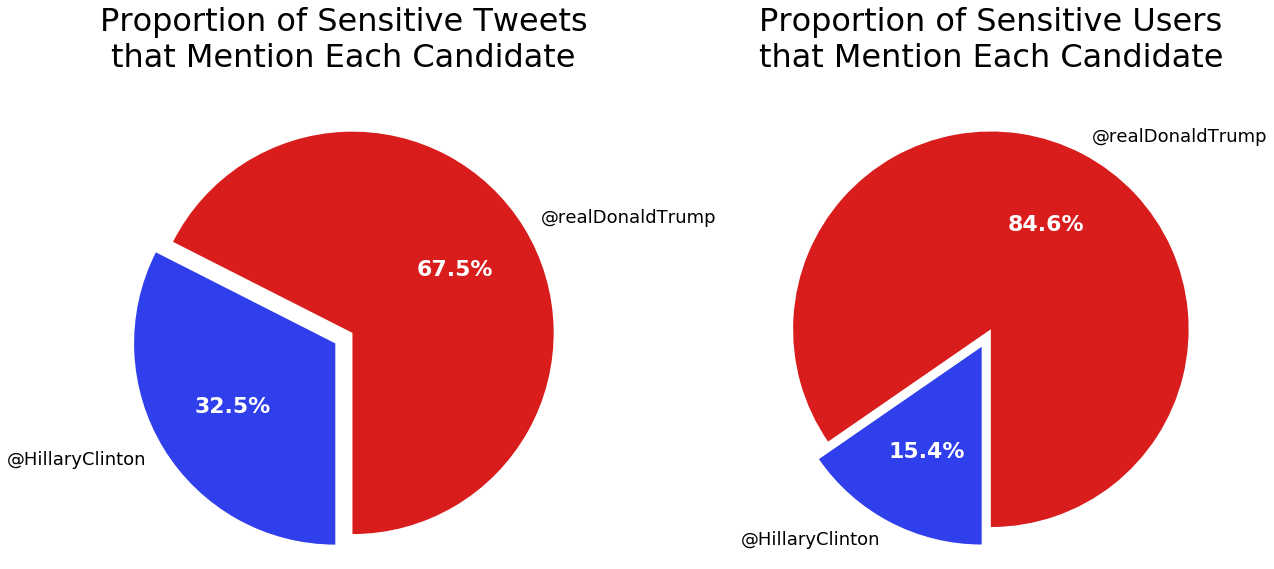

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax1, ax2 = axes.flatten()

# Left axis
candidates = ['@realDonaldTrump', '@HillaryClinton']
amounts = num_sens_tweets
percentage_sales = np.array(amounts)/sum(amounts)
colors = ['#d91c1c', '#2f3feb']
explode = [0]*2
explode[0] = 0.1

patches, texts, autotexts = ax1.pie(percentage_sales, 
                                    colors=colors, 
                                    labels=candidates, 
                                    autopct='%1.1f%%',
                                    explode=explode,
                                    startangle=-90,
                                    shadow=False)

for i in range(0,2):
    texts[i].set_fontsize(18)
    autotexts[i].set_fontsize(22)
    autotexts[i].set_color('white')
    autotexts[i].set_weight('bold')
    
ax1.set_title('Proportion of Sensitive Tweets\nthat Mention Each Candidate', fontsize=32, y=1.1)
ax1.axis('equal') 

# Right axis
candidates = ['@realDonaldTrump', '@HillaryClinton']
amounts = num_sens_users
percentage_sales = np.array(amounts)/sum(amounts)
colors = ['#d91c1c', '#2f3feb']
explode = [0]*2
explode[0] = 0.1

patches, texts, autotexts = ax2.pie(percentage_sales, 
                                    colors=colors, 
                                    labels=candidates, 
                                    autopct='%1.1f%%',
                                    explode=explode,
                                    startangle=-90,
                                    shadow=False)

for i in range(0,2):
    texts[i].set_fontsize(18)
    autotexts[i].set_fontsize(22)
    autotexts[i].set_color('white')
    autotexts[i].set_weight('bold')
    
ax2.set_title("Proportion of Sensitive Users\nthat Mention Each Candidate", fontsize=32, y=1.1)
ax2.axis('equal') 
plt.tight_layout()
plt.savefig('figs/sensitive_tweets.eps', format='eps', dpi=900)

---
## Andrew/Tycho Sentiment Analysis
Takes every tweet id and **maps its corresponding sentiment to the candidate of interest**. Such candidate interest is (for now - feel free to add ideas) given by:

- What candidate each tweet mentions.
- What candidate hashtag each tweet includes (_important to address whether the hashtag is with or against the candidate_).

In [ ]:
import pickle

with open('50K_tweets_with_sentiment_prediction.pkl', 'rb') as f:
    data = pickle.load(f)

In [ ]:
# 1: Trump
trues_trump = []
for tweet_id in data['_id']:
    if tweet_id in user_mentions.loc[0]['mentioned_in']:
        trues_trump.append(True)
        
print("Number of sensitive tweets mentioning 'realDonaldTrump':", sum(trues_trump))

In [ ]:
# 1: Hillary
trues_hillary = []
for tweet_id in data['_id']:
    if tweet_id in user_mentions.loc[1]['mentioned_in']:
        trues_hillary.append(True)

num_pred_tweets = [sum(trues_trump), sum(trues_hillary)]

print("Number of sensitive tweets mentioning 'HillaryClinton':", sum(trues_hillary))

# Hashtag Analysis - From Milos Work 

In [170]:
hashtags = pd.read_csv('Hashtag_df.csv')

trump_hashtags = [s for s in hashtags['hashtag'] if ("trump" or "Trump") in s]
hillary_hashtags = [x for x in hashtags['hashtag'] if ("hillary" or "Hillary") in x]

print("Number of Trump hashtags in df:", len(trump_hashtags))
print("Number of Hillary hashtags in df:", len(hillary_hashtags))

Number of Trump hashtags in df: 3114
Number of Hillary hashtags in df: 1468


In [171]:
pos_hashtags = hashtags.loc[hashtags['sentiment'] > 0]['hashtag']
neg_hashtags = hashtags.loc[hashtags['sentiment'] < 0]['hashtag']
neutral_hashtags = hashtags.loc[hashtags['sentiment'] == 0]['hashtag']

pos_trump = [s.replace(" ","") for s in pos_hashtags if ("trump" or "Trump") in s]
neg_trump = [s.replace(" ","") for s in neg_hashtags if ("trump" or "Trump") in s]
neutral_trump = [s.replace(" ","") for s in neutral_hashtags if ("trump" or "Trump") in s]

pos_hillary = [s.replace(" ","") for s in pos_hashtags if ("hillary" or "Hillary") in s]
neg_hillary = [s.replace(" ","") for s in neg_hashtags if ("hillary" or "Hillary") in s]
neutral_hillary = [s.replace(" ","") for s in neutral_hashtags if ("hillary" or "Hillary") in s]

In [173]:
num_hashtags = 100

hashtags_date = pd.DataFrame(columns=['hashtag', 'date', 'sentiment', 'candidate'])

for h in tqdm(pos_trump[0:num_hashtags]):
    results = pd.Series(twitter_db.find(filter = {"entities.hashtags.text" : h}, projection={"created_at":1, "_id":0}))
    aux_df = pd.DataFrame(data={'hashtag': len(results) * [h], 
                                'date': results,
                                'sentiment': len(results) * ['pos'], 
                                'candidate': len(results) * ['trump']})

    hashtags_date = pd.concat([hashtags_date, aux_df], axis=0)
    
for h in tqdm(neg_trump[0:num_hashtags]):
    results = pd.Series(twitter_db.find(filter = {"entities.hashtags.text" : h}, projection={"created_at":1, "_id":0}))
    aux_df = pd.DataFrame(data={'hashtag': len(results) * [h], 
                                'date': results,
                                'sentiment': len(results) * ['neg'], 
                                'candidate': len(results) * ['trump']})

    hashtags_date = pd.concat([hashtags_date, aux_df], axis=0)
    
for h in tqdm(neutral_trump[0:num_hashtags]):
    results = pd.Series(twitter_db.find(filter = {"entities.hashtags.text" : h}, projection={"created_at":1, "_id":0}))
    aux_df = pd.DataFrame(data={'hashtag': len(results) * [h], 
                                'date': results,
                                'sentiment': len(results) * ['neutral'], 
                                'candidate': len(results) * ['trump']})

    hashtags_date = pd.concat([hashtags_date, aux_df], axis=0)
    
for h in tqdm(pos_hillary[0:num_hashtags]):
    results = pd.Series(twitter_db.find(filter = {"entities.hashtags.text" : h}, projection={"created_at":1, "_id":0}))
    aux_df = pd.DataFrame(data={'hashtag': len(results) * [h], 
                                'date': results,
                                'sentiment': len(results) * ['pos'], 
                                'candidate': len(results) * ['hillary']})

    hashtags_date = pd.concat([hashtags_date, aux_df], axis=0)
    
for h in tqdm(neg_hillary[0:num_hashtags]):
    results = pd.Series(twitter_db.find(filter = {"entities.hashtags.text" : h}, projection={"created_at":1, "_id":0}))
    aux_df = pd.DataFrame(data={'hashtag': len(results) * [h], 
                                'date': results,
                                'sentiment': len(results) * ['neg'], 
                                'candidate': len(results) * ['hillary']})

    hashtags_date = pd.concat([hashtags_date, aux_df], axis=0)
    
for h in tqdm(neutral_hillary[0:num_hashtags]):
    results = pd.Series(twitter_db.find(filter = {"entities.hashtags.text" : h}, projection={"created_at":1, "_id":0}))
    aux_df = pd.DataFrame(data={'hashtag': len(results) * [h], 
                                'date': results,
                                'sentiment': len(results) * ['neutral'], 
                                'candidate': len(results) * ['hillary']})

    hashtags_date = pd.concat([hashtags_date, aux_df], axis=0)







  0%|          | 0/100 [00:00<?, ?it/s]





  1%|          | 1/100 [00:01<01:43,  1.05s/it]





  2%|▏         | 2/100 [00:02<01:41,  1.04s/it]





  3%|▎         | 3/100 [00:03<01:40,  1.04s/it]





  4%|▍         | 4/100 [00:04<01:40,  1.04s/it]





  5%|▌         | 5/100 [00:05<01:38,  1.04s/it]





  6%|▌         | 6/100 [00:06<01:36,  1.03s/it]





  7%|▋         | 7/100 [00:07<01:35,  1.03s/it]





  8%|▊         | 8/100 [00:08<01:35,  1.03s/it]





  9%|▉         | 9/100 [00:09<01:35,  1.05s/it]





 10%|█         | 10/100 [00:10<01:34,  1.05s/it]





 11%|█         | 11/100 [00:11<01:32,  1.04s/it]





 12%|█▏        | 12/100 [00:12<01:30,  1.03s/it]





 13%|█▎        | 13/100 [00:13<01:30,  1.04s/it]





 14%|█▍        | 14/100 [00:14<01:28,  1.03s/it]





 15%|█▌        | 15/100 [00:15<01:26,  1.02s/it]





 16%|█▌        | 16/100 [00:16<01:25,  1.02s/it]





 17%|█▋        | 17/100 [00:17<01:24,  1.02s/it]





 18%|█▊        | 18/100 [00:18<01:23,  1

 13%|█▎        | 13/100 [00:13<01:29,  1.03s/it]





 14%|█▍        | 14/100 [00:14<01:28,  1.02s/it]





 15%|█▌        | 15/100 [00:15<01:27,  1.03s/it]





 16%|█▌        | 16/100 [00:16<01:26,  1.02s/it]





 17%|█▋        | 17/100 [00:17<01:24,  1.02s/it]





 18%|█▊        | 18/100 [00:18<01:23,  1.02s/it]





 19%|█▉        | 19/100 [00:19<01:22,  1.01s/it]





 20%|██        | 20/100 [00:20<01:21,  1.02s/it]





 21%|██        | 21/100 [00:21<01:21,  1.03s/it]





 22%|██▏       | 22/100 [00:22<01:19,  1.02s/it]





 23%|██▎       | 23/100 [00:23<01:18,  1.02s/it]





 24%|██▍       | 24/100 [00:24<01:17,  1.03s/it]





 25%|██▌       | 25/100 [00:26<01:17,  1.04s/it]





 26%|██▌       | 26/100 [00:27<01:16,  1.04s/it]





 27%|██▋       | 27/100 [00:28<01:15,  1.04s/it]





 28%|██▊       | 28/100 [00:29<01:14,  1.03s/it]





 29%|██▉       | 29/100 [00:30<01:13,  1.03s/it]





 30%|███       | 30/100 [00:31<01:12,  1.03s/it]





 31%|███       | 31/100 [00:

 26%|██▌       | 26/100 [00:26<01:14,  1.01s/it]





 27%|██▋       | 27/100 [00:27<01:13,  1.01s/it]





 28%|██▊       | 28/100 [00:28<01:12,  1.00s/it]





 29%|██▉       | 29/100 [00:29<01:11,  1.00s/it]





 30%|███       | 30/100 [00:30<01:10,  1.00s/it]





 31%|███       | 31/100 [00:31<01:09,  1.01s/it]





 32%|███▏      | 32/100 [00:32<01:08,  1.01s/it]





 33%|███▎      | 33/100 [00:33<01:07,  1.01s/it]





 34%|███▍      | 34/100 [00:34<01:07,  1.03s/it]





 35%|███▌      | 35/100 [00:35<01:06,  1.03s/it]





 36%|███▌      | 36/100 [00:36<01:05,  1.03s/it]





 37%|███▋      | 37/100 [00:37<01:04,  1.02s/it]





 38%|███▊      | 38/100 [00:38<01:03,  1.02s/it]





 39%|███▉      | 39/100 [00:39<01:02,  1.02s/it]





 40%|████      | 40/100 [00:40<01:02,  1.03s/it]





 41%|████      | 41/100 [00:41<01:00,  1.03s/it]





 42%|████▏     | 42/100 [00:42<00:59,  1.03s/it]





 43%|████▎     | 43/100 [00:43<00:58,  1.03s/it]





 44%|████▍     | 44/100 [00:

 52%|█████▏    | 39/75 [00:39<00:36,  1.02s/it]





 53%|█████▎    | 40/75 [00:40<00:35,  1.01s/it]





 55%|█████▍    | 41/75 [00:41<00:34,  1.01s/it]





 56%|█████▌    | 42/75 [00:42<00:33,  1.02s/it]





 57%|█████▋    | 43/75 [00:43<00:32,  1.02s/it]





 59%|█████▊    | 44/75 [00:44<00:31,  1.01s/it]





 60%|██████    | 45/75 [00:45<00:30,  1.00s/it]





 61%|██████▏   | 46/75 [00:46<00:29,  1.00s/it]





 63%|██████▎   | 47/75 [00:47<00:28,  1.02s/it]





 64%|██████▍   | 48/75 [00:48<00:27,  1.02s/it]





 65%|██████▌   | 49/75 [00:49<00:26,  1.02s/it]





 67%|██████▋   | 50/75 [00:50<00:25,  1.02s/it]





 68%|██████▊   | 51/75 [00:51<00:24,  1.02s/it]





 69%|██████▉   | 52/75 [00:52<00:23,  1.02s/it]





 71%|███████   | 53/75 [00:53<00:22,  1.01s/it]





 72%|███████▏  | 54/75 [00:54<00:21,  1.00s/it]





 73%|███████▎  | 55/75 [00:55<00:20,  1.01s/it]





 75%|███████▍  | 56/75 [00:56<00:19,  1.01s/it]





 76%|███████▌  | 57/75 [00:57<00:18,  1.02s/it

 77%|███████▋  | 77/100 [01:19<00:23,  1.03s/it]





 78%|███████▊  | 78/100 [01:20<00:22,  1.03s/it]





 79%|███████▉  | 79/100 [01:21<00:21,  1.04s/it]





 80%|████████  | 80/100 [01:22<00:20,  1.04s/it]





 81%|████████  | 81/100 [01:23<00:19,  1.04s/it]





 82%|████████▏ | 82/100 [01:24<00:18,  1.03s/it]





 83%|████████▎ | 83/100 [01:25<00:17,  1.04s/it]





 84%|████████▍ | 84/100 [01:26<00:16,  1.03s/it]





 85%|████████▌ | 85/100 [01:27<00:15,  1.03s/it]





 86%|████████▌ | 86/100 [01:28<00:14,  1.02s/it]





 87%|████████▋ | 87/100 [01:29<00:13,  1.02s/it]





 88%|████████▊ | 88/100 [01:30<00:12,  1.03s/it]





 89%|████████▉ | 89/100 [01:31<00:11,  1.03s/it]





 90%|█████████ | 90/100 [01:32<00:10,  1.02s/it]





 91%|█████████ | 91/100 [01:33<00:09,  1.01s/it]





 92%|█████████▏| 92/100 [01:34<00:08,  1.01s/it]





 93%|█████████▎| 93/100 [01:35<00:07,  1.02s/it]





 94%|█████████▍| 94/100 [01:36<00:06,  1.02s/it]





 95%|█████████▌| 95/100 [01:

 90%|█████████ | 90/100 [01:32<00:10,  1.03s/it]





 91%|█████████ | 91/100 [01:33<00:09,  1.04s/it]





 92%|█████████▏| 92/100 [01:34<00:08,  1.03s/it]





 93%|█████████▎| 93/100 [01:35<00:07,  1.03s/it]





 94%|█████████▍| 94/100 [01:36<00:06,  1.02s/it]





 95%|█████████▌| 95/100 [01:37<00:05,  1.02s/it]





 96%|█████████▌| 96/100 [01:38<00:04,  1.03s/it]





 97%|█████████▋| 97/100 [01:39<00:03,  1.03s/it]





 98%|█████████▊| 98/100 [01:41<00:02,  1.03s/it]





 99%|█████████▉| 99/100 [01:42<00:01,  1.03s/it]





100%|██████████| 100/100 [01:43<00:00,  1.04s/it]

In [180]:
print(hashtags_date.isnull().sum())
hashtags_date.head()

hashtag      0
date         0
sentiment    0
candidate    0
dtype: int64


,hashtag,date,sentiment,candidate
0,defeattrump,{'created_at': 'Thu Aug 25 16:00:09 +0000 2016'},pos,trump
0,trumpnotwelcome,{'created_at': 'Wed Aug 31 16:20:22 +0000 2016'},pos,trump
0,trumpwins,{'created_at': 'Tue Aug 30 03:17:48 +0000 2016'},pos,trump
0,trumpfreezone,{'created_at': 'Sun Aug 21 16:44:55 +0000 2016'},pos,trump
1,trumpfreezone,{'created_at': 'Thu Sep 01 15:11:40 +0000 2016'},pos,trump


In [182]:
import time

hashtags_date['date'] = [x['created_at'] for x in hashtags_date['date']]
hashtags_date['date'] = hashtags_date['date'].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.strptime(x,'%a %b %d %H:%M:%S +0000 %Y')))
hashtags_date['day'] = [x[0] for x in hashtags_date['date'].str.split(" ")]
hashtags_date['time'] = [x[1] for x in hashtags_date['date'].str.split(" ")]

In [211]:
hashtags_date_trump = hashtags_date[hashtags_date['candidate'] == 'trump']
hashtag_days_trump = hashtags_date_trump.groupby('day', as_index=False).count()['day']
hashtag_count_trump = hashtags_date_trump.groupby(['day', 'sentiment'], as_index=False).count()

hashtags_date_hillary = hashtags_date[hashtags_date['candidate'] == 'hillary']
hashtags_days_hillary = hashtags_date_hillary.groupby('day', as_index=False).count()['day']
hashtag_count_hillary = hashtags_date_hillary.groupby(['day', 'sentiment'], as_index=False).count()

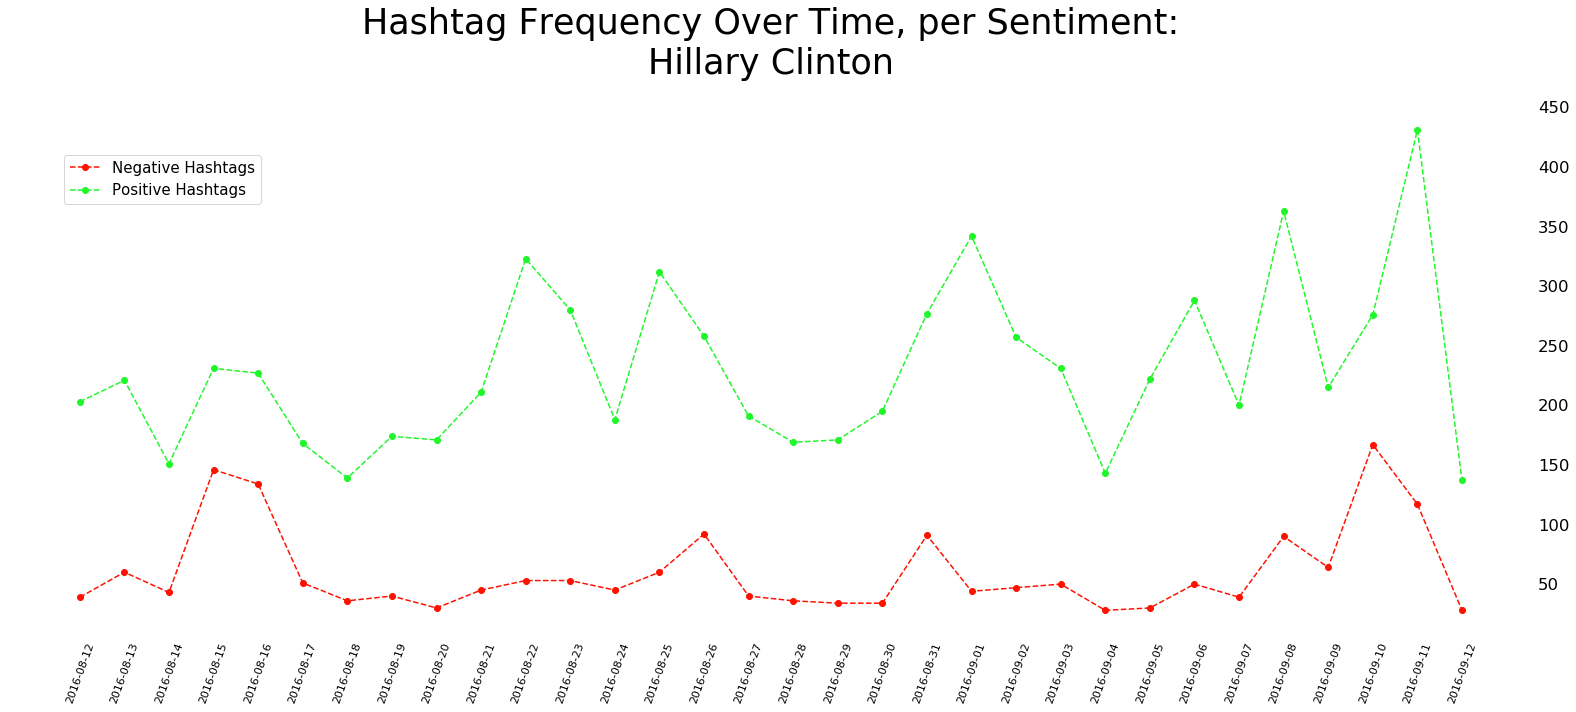

In [247]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(22,10))
colors = ['#ff1100', '#20f72b']

for idx, s in enumerate(['neg', 'neutral']):
    days_H = hashtag_count_hillary[hashtag_count_hillary['sentiment'] == s]['day']
    axes.plot(days_H, hashtag_count_hillary[hashtag_count_hillary['sentiment'] == s]['date'], color=colors[idx], linestyle='--', marker='o')


plt.title('Hashtag Frequency Over Time, per Sentiment:\nHillary Clinton', fontsize=35, y=1.05)
# plt.xlabel('Date', fontsize=24, labelpad=20)
plt.tick_params(axis = 'y', labelsize = 16.5)
plt.tick_params(axis = 'x', labelsize = 11)
plt.xticks(rotation=70)
axes.spines["top"].set_visible(False)
axes.spines["left"].set_visible(False)
axes.spines["right"].set_visible(False)
axes.spines["bottom"].set_visible(False)
axes.yaxis.set_label_position("right")
axes.yaxis.tick_right()
plt.tick_params(top="off", left="off", right="off", bottom='off')

L = plt.legend(loc=3, bbox_to_anchor=(0.03,0.8), fontsize=15)
L.get_texts()[0].set_text('Negative Hashtags')
L.get_texts()[1].set_text('Positive Hashtags')
# L.get_texts()[2].set_text('Mentioning @realDonaldTrump')

plt.tight_layout()
plt.savefig('figs/hashtag_hillary.eps', format='eps', dpi=900)
plt.show();

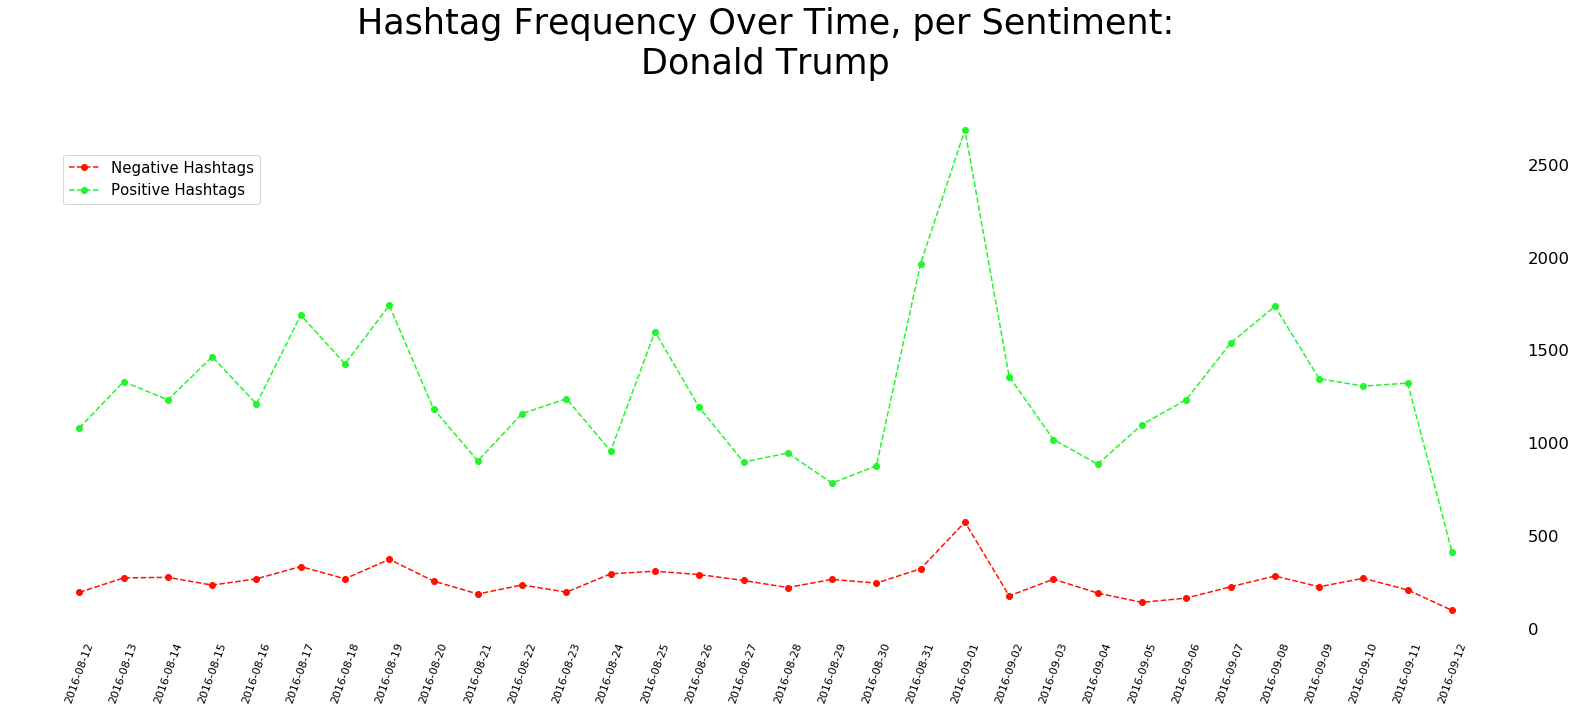

In [248]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(22,10))
colors = ['#ff1100', '#20f72b']

for idx, s in enumerate(['neg', 'neutral']):
    days_T = hashtag_count_trump[hashtag_count_trump['sentiment'] == s]['day']
    axes.plot(days_T, hashtag_count_trump[hashtag_count_trump['sentiment'] == s]['date'], color=colors[idx], linestyle='--', marker='o')


plt.title('Hashtag Frequency Over Time, per Sentiment:\nDonald Trump', fontsize=35, y=1.05)
# plt.xlabel('Date', fontsize=24, labelpad=20)
plt.tick_params(axis = 'y', labelsize = 16.5)
plt.tick_params(axis = 'x', labelsize = 11)
plt.xticks(rotation=70)
axes.spines["top"].set_visible(False)
axes.spines["left"].set_visible(False)
axes.spines["right"].set_visible(False)
axes.spines["bottom"].set_visible(False)
axes.yaxis.set_label_position("right")
axes.yaxis.tick_right()
plt.tick_params(top="off", left="off", right="off", bottom='off')

L = plt.legend(loc=3, bbox_to_anchor=(0.03,0.8), fontsize=15)
L.get_texts()[0].set_text('Negative Hashtags')
L.get_texts()[1].set_text('Positive Hashtags')
# L.get_texts()[2].set_text('Mentioning @realDonaldTrump')

plt.tight_layout()
plt.savefig('figs/hashtag_trump.eps', format='eps', dpi=900)
plt.show();

---
# Time Series Analysis

In [249]:
time_tweets = pd.DataFrame(columns = ['date'])
time_tweets['date'] = pd.Series(twitter_db.find( projection={ "created_at":1, "_id":0 } ))
time_tweets.drop(0, inplace=True)
time_tweets['date'] = [x['created_at'] for x in time_tweets['date']]

time_tweets.head()

,date
1,Fri Aug 12 10:04:00 +0000 2016
2,Fri Aug 12 10:04:02 +0000 2016
3,Fri Aug 12 10:04:10 +0000 2016
4,Fri Aug 12 10:04:21 +0000 2016
5,Fri Aug 12 10:04:30 +0000 2016


In [250]:
import time

time_tweets['date'] = time_tweets['date'].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.strptime(x,'%a %b %d %H:%M:%S +0000 %Y')))
time_tweets['day'] = [x[0] for x in time_tweets['date'].str.split(" ")]
time_tweets['time'] = [x[1] for x in time_tweets['date'].str.split(" ")]

time_tweets.head()

,date,day,time
1,2016-08-12 10:04:00,2016-08-12,10:04:00
2,2016-08-12 10:04:02,2016-08-12,10:04:02
3,2016-08-12 10:04:10,2016-08-12,10:04:10
4,2016-08-12 10:04:21,2016-08-12,10:04:21
5,2016-08-12 10:04:30,2016-08-12,10:04:30


## Tweet Frequency Over Time

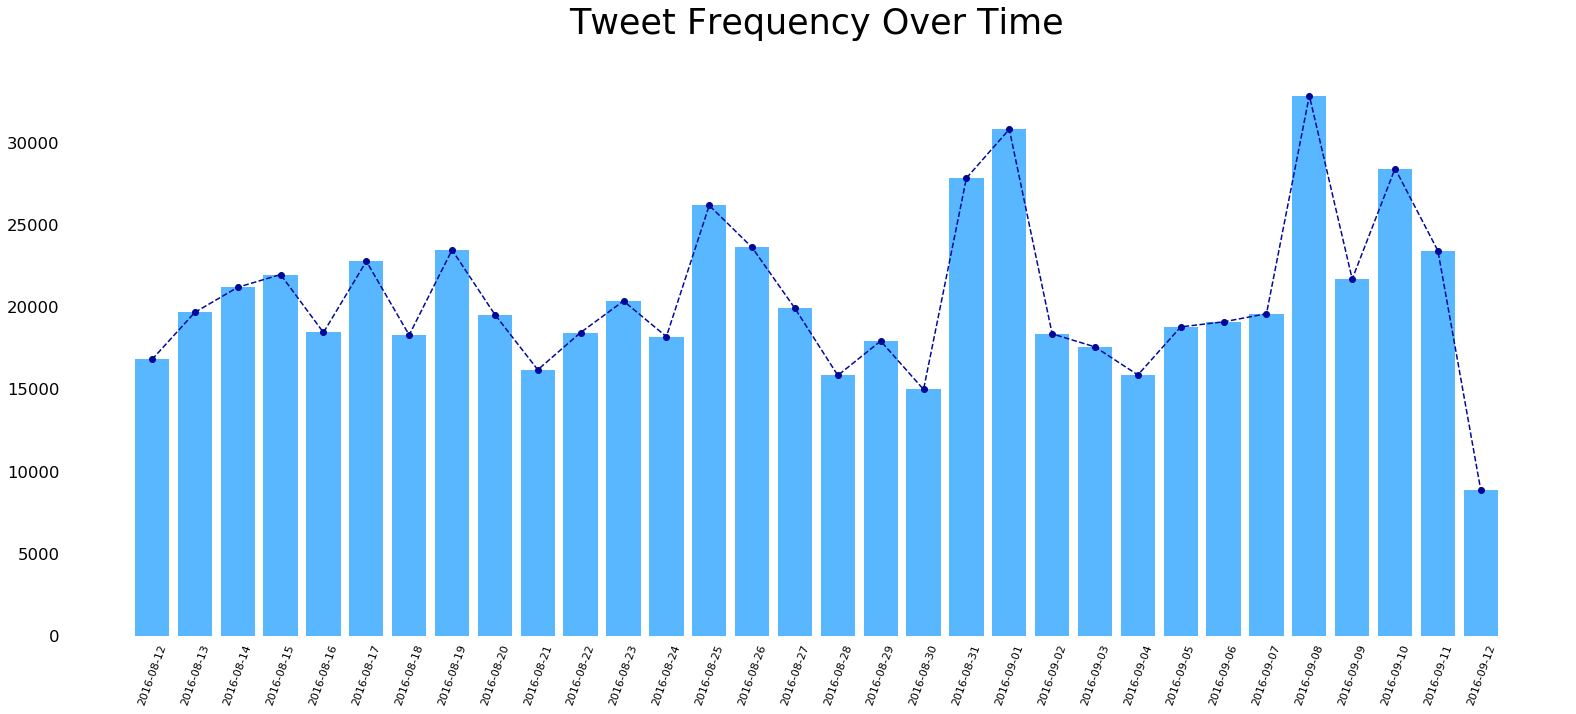

In [251]:
distinct_days = time_tweets.groupby('day', as_index=False).count()['day']
count_per_day = time_tweets.groupby('day', as_index=False).count()['date']

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(22,10))

ax1 = plt.bar(distinct_days, count_per_day, color='#59b7ff')
axes.plot(distinct_days, count_per_day, color='#000899', linestyle='--', marker='o')

plt.title('Tweet Frequency Over Time', fontsize=35, y=1.05)
# plt.xlabel('Date', fontsize=24, labelpad=20)
plt.tick_params(top="off", left="off", right="off", bottom='off')
plt.tick_params(axis = 'y', labelsize = 16.5)
plt.tick_params(axis = 'x', labelsize = 11)
plt.xticks(rotation=70)
axes.spines["top"].set_visible(False)
axes.spines["left"].set_visible(False)
axes.spines["right"].set_visible(False)
axes.spines["bottom"].set_visible(False)

plt.tight_layout()
plt.savefig('figs/tweet_freq_over_time.eps', format='eps', dpi=900)
plt.show();

## Tweet Frequency per Month/Day/Hour

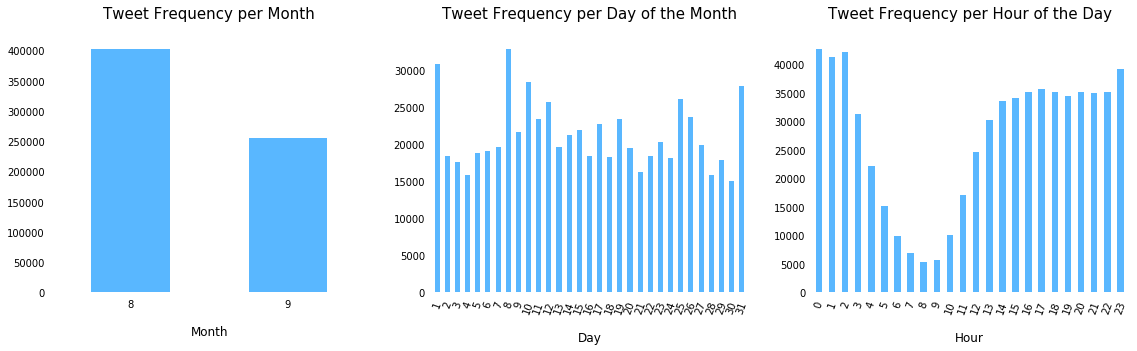

In [252]:
time_tweets_date = time_tweets["date"].astype("datetime64")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,5))
ax1, ax2, ax3 = axes.flatten()

time_tweets_date.groupby(time_tweets_date.dt.month).count().plot(kind="bar", ax=ax1, color='#59b7ff')
time_tweets_date.groupby(time_tweets_date.dt.day).count().plot(kind="bar", ax=ax2, color='#59b7ff')
time_tweets_date.groupby(time_tweets_date.dt.hour).count().plot(kind="bar", ax=ax3, color='#59b7ff')

ax1.set_title('Tweet Frequency per Month', fontsize=15, y=1.05)
ax2.set_title('Tweet Frequency per Day of the Month', fontsize=15, y=1.05)
ax3.set_title('Tweet Frequency per Hour of the Day', fontsize=15, y=1.05)

ax1.tick_params(top="off", left="off", right="off", bottom='off')
ax2.tick_params(top="off", left="off", right="off", bottom='off')
ax3.tick_params(top="off", left="off", right="off", bottom='off')

ax1.spines["top"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["bottom"].set_visible(False)
ax3.spines["top"].set_visible(False)
ax3.spines["left"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

ax1.set_xlabel('Month', fontsize=12, labelpad=16)
ax2.set_xlabel('Day', fontsize=12, labelpad=16)
ax3.set_xlabel('Hour', fontsize=12, labelpad=16)

for tick in ax1.get_xticklabels():
    tick.set_rotation(0)
for tick in ax2.get_xticklabels():
    tick.set_rotation(70)
for tick in ax3.get_xticklabels():
    tick.set_rotation(70)

plt.tight_layout()
plt.savefig('figs/tweet_freq_per.eps', format='eps', dpi=900)
plt.show()

## Candidate Mentions over Time

In [253]:
tweets_trump = pd.DataFrame(columns = ['date'])
tweets_hillary = pd.DataFrame(columns = ['date'])

tweets_trump['date'] = pd.Series(twitter_db.find(filter = {"entities.user_mentions.screen_name": 'realDonaldTrump'}, projection={"created_at": 1, "_id": 0}))
tweets_trump['date'] = [x['created_at'] for x in tweets_trump['date']]

tweets_hillary['date'] = pd.Series(twitter_db.find(filter = {"entities.user_mentions.screen_name": 'HillaryClinton'}, projection={"created_at": 1, "_id": 0}))
tweets_hillary['date'] = [x['created_at'] for x in tweets_hillary['date']]

In [254]:
tweets_trump['date'] = tweets_trump['date'].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.strptime(x,'%a %b %d %H:%M:%S +0000 %Y')))
tweets_trump['day'] = [x[0] for x in tweets_trump['date'].str.split(" ")]
tweets_trump['time'] = [x[1] for x in tweets_trump['date'].str.split(" ")]

tweets_hillary['date'] = tweets_hillary['date'].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.strptime(x,'%a %b %d %H:%M:%S +0000 %Y')))
tweets_hillary['day'] = [x[0] for x in tweets_hillary['date'].str.split(" ")]
tweets_hillary['time'] = [x[1] for x in tweets_hillary['date'].str.split(" ")]

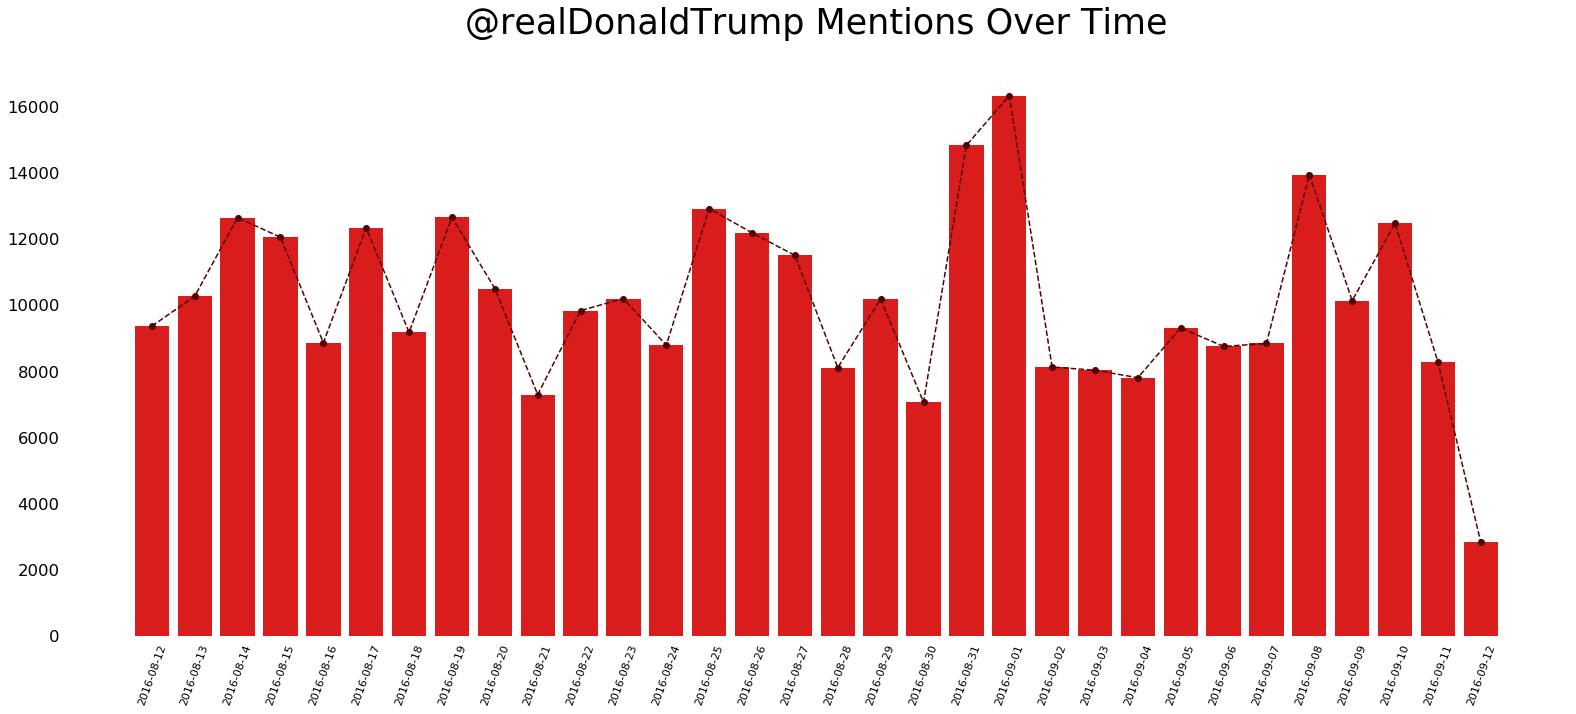

In [255]:
distinct_days_trump = tweets_trump.groupby('day', as_index=False).count()['day']
count_per_day_trump = tweets_trump.groupby('day', as_index=False).count()['date']

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(22,10))

ax1 = plt.bar(distinct_days_trump, count_per_day_trump, color='#d91c1c')
axes.plot(distinct_days_trump, count_per_day_trump, color='#540000', linestyle='--', marker='o')

plt.title('@realDonaldTrump Mentions Over Time', fontsize=35, y=1.05)
# plt.xlabel('Date', fontsize=24, labelpad=20)
plt.tick_params(top="off", left="off", right="off", bottom='off')
plt.tick_params(axis = 'y', labelsize = 16.5)
plt.tick_params(axis = 'x', labelsize = 11)
plt.xticks(rotation=70)
axes.spines["top"].set_visible(False)
axes.spines["left"].set_visible(False)
axes.spines["right"].set_visible(False)
axes.spines["bottom"].set_visible(False)

plt.tight_layout()
plt.savefig('figs/mentions_trump.eps', format='eps', dpi=900)
plt.show();

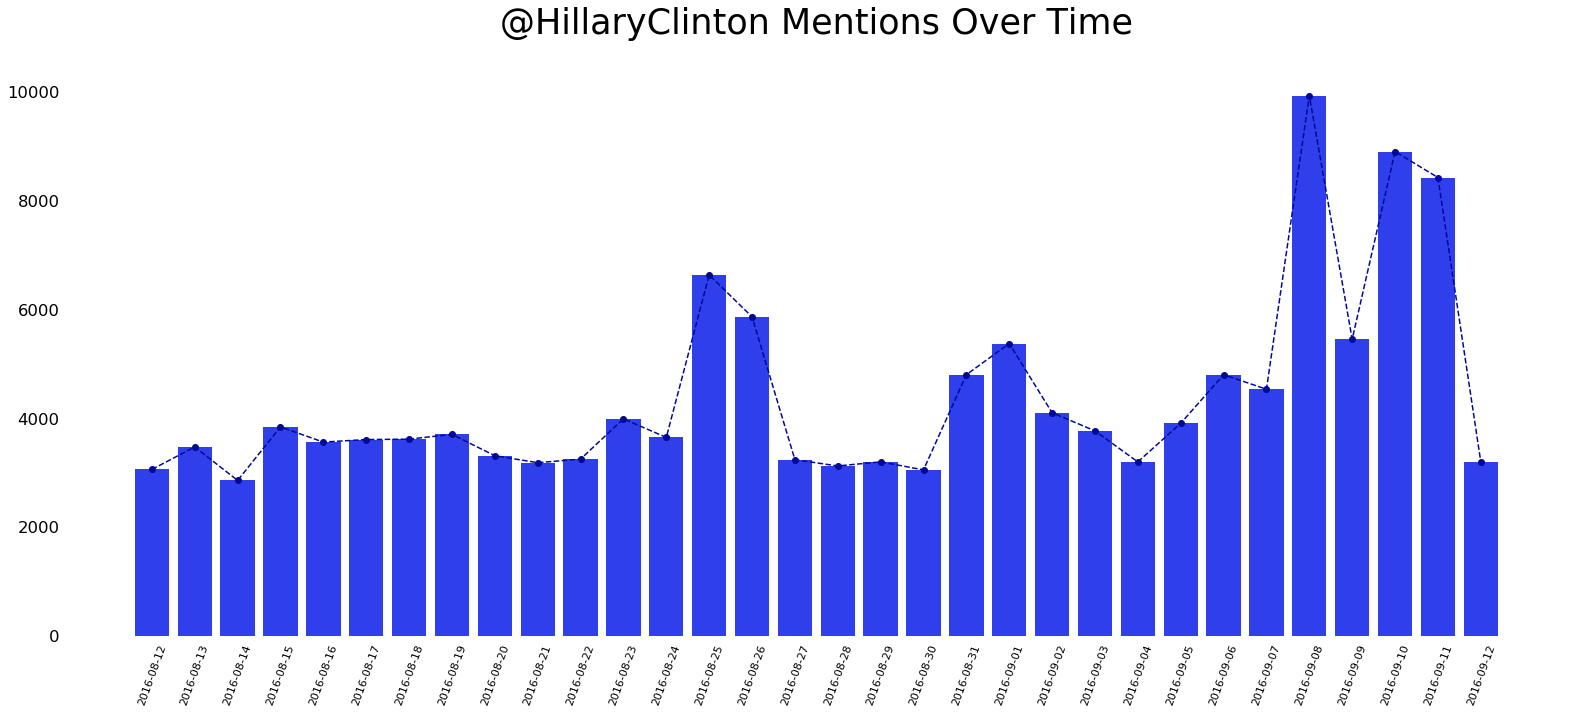

In [256]:
distinct_days_hillary = tweets_hillary.groupby('day', as_index=False).count()['day']
count_per_day_hillary = tweets_hillary.groupby('day', as_index=False).count()['date']

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(22,10))

ax1 = plt.bar(distinct_days_hillary, count_per_day_hillary, color='#2f3feb')
axes.plot(distinct_days_hillary, count_per_day_hillary, color='#000899', linestyle='--', marker='o')

plt.title('@HillaryClinton Mentions Over Time', fontsize=35, y=1.05)
# plt.xlabel('Date', fontsize=24, labelpad=20)
plt.tick_params(top="off", left="off", right="off", bottom='off')
plt.tick_params(axis = 'y', labelsize = 16.5)
plt.tick_params(axis = 'x', labelsize = 11)
plt.xticks(rotation=70)
axes.spines["top"].set_visible(False)
axes.spines["left"].set_visible(False)
axes.spines["right"].set_visible(False)
axes.spines["bottom"].set_visible(False)

plt.tight_layout()
plt.savefig('figs/mentions_hillary.eps', format='eps', dpi=900)
plt.show();

## All combined (Cleaner Visualization)

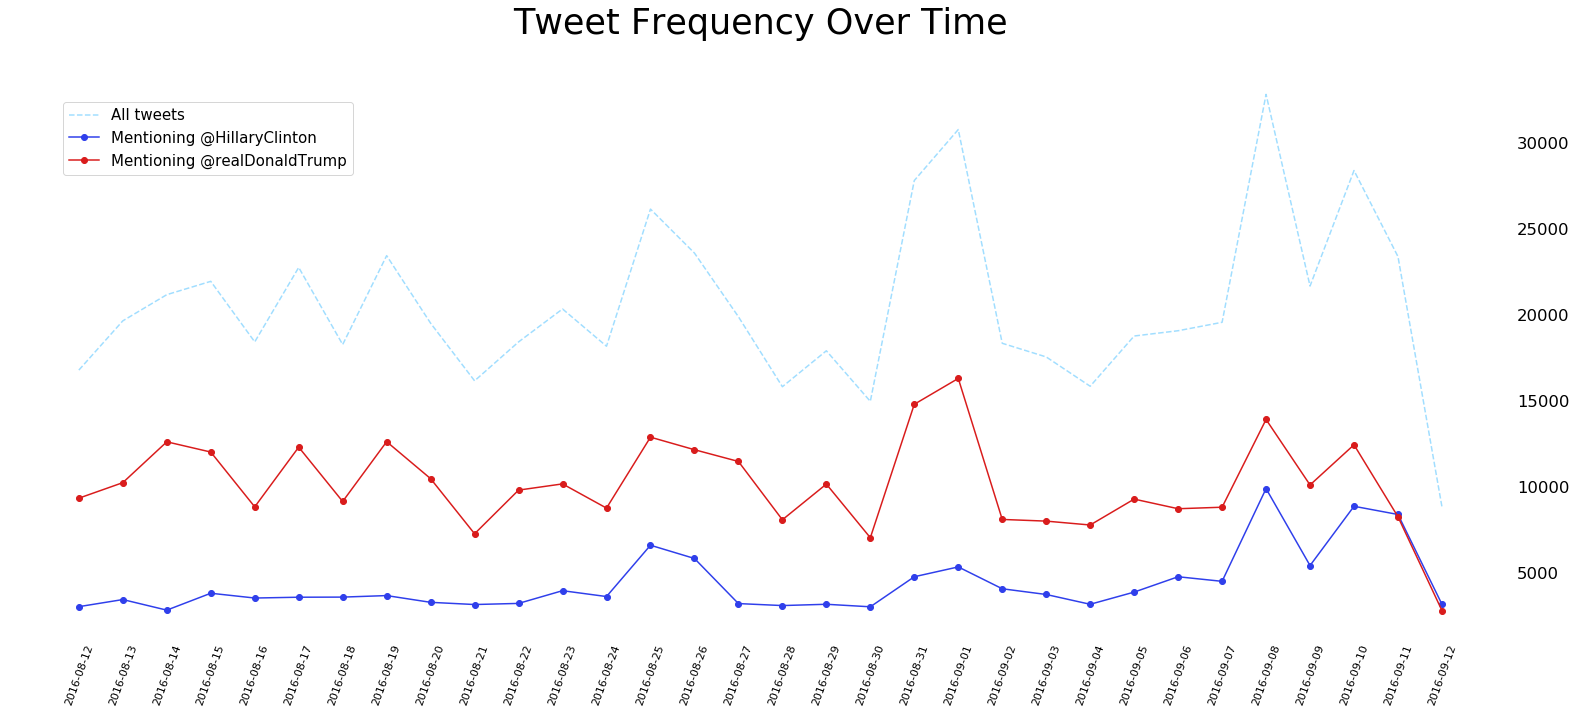

In [257]:
# All tweets
distinct_days = time_tweets.groupby('day', as_index=False).count()['day']
count_per_day = time_tweets.groupby('day', as_index=False).count()['date']

# Trump mentions
distinct_days_trump = tweets_trump.groupby('day', as_index=False).count()['day']
count_per_day_trump = tweets_trump.groupby('day', as_index=False).count()['date']

# Hillary mentions
distinct_days_hillary = tweets_hillary.groupby('day', as_index=False).count()['day']
count_per_day_hillary = tweets_hillary.groupby('day', as_index=False).count()['date']

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(22,10))

axes.plot(distinct_days, count_per_day, color='#a1deff', linestyle='--')
axes.plot(distinct_days_hillary, count_per_day_hillary, color='#2f3feb', marker='o')
axes.plot(distinct_days_trump, count_per_day_trump, color='#d91c1c', marker='o')

plt.title('Tweet Frequency Over Time', fontsize=35, y=1.05)
# plt.xlabel('Date', fontsize=24, labelpad=20)
plt.tick_params(axis = 'y', labelsize = 16.5)
plt.tick_params(axis = 'x', labelsize = 11)
plt.xticks(rotation=70)
axes.spines["top"].set_visible(False)
axes.spines["left"].set_visible(False)
axes.spines["right"].set_visible(False)
axes.spines["bottom"].set_visible(False)
axes.yaxis.set_label_position("right")
axes.yaxis.tick_right()
plt.tick_params(top="off", left="off", right="off", bottom='off')


'''
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='#a1deff', label='All')
blue_patch = mpatches.Patch(color='#2f3feb', label='Mentioning @HillaryClinton')
total_patch = mpatches.Patch(color='#d91c1c', label='Mentioning @DonaldTrump')
plt.legend(handles=[red_patch, blue_patch, total_patch], fontsize=15)
'''

L = plt.legend(loc=3, bbox_to_anchor=(0.03,0.8), fontsize=15)
L.get_texts()[0].set_text('All tweets')
L.get_texts()[1].set_text('Mentioning @HillaryClinton')
L.get_texts()[2].set_text('Mentioning @realDonaldTrump')

plt.tight_layout()
plt.savefig('figs/combined.eps', format='eps', dpi=900)
plt.show();